# Dimensionality Reduction
In this best practices notebook, we will use the [QM7 dataset](http://quantum-machine.org/datasets/) as a toy example to discuss and demonstrate the benefits of dimensionality reduction techniques in exploring the chemical space. The dataset comprises 7165 organic molecules with diverse sizes (up to 23 atoms) and chemical compositions, featuring heavy elements such as C, N, O, and S. In addition to the three-dimensional molecular strucutres available either as standard Cartesian coordinates or in the Coulomb matrix representation, the QM7 dataset also provides atomization energies for each compound calculated using Density Functional Theory (DFT).

To run this notebook, you will need to use a kernel with the following libraries installed:
* RDKit
* Pandas
* ipykernel

## Environment setup
Below we install the necessary Python libraries and define some functions we will need lated.

In [ ]:
# Install and update required packages
!pip install pacmap -U
!pip install py3Dmol -U
!pip install scikit-learn -U
!pip install pandas -U
!pip install seaborn -U

In [11]:
# Import math library
import numpy as np

# Import libraries for data handling and visualization
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import py3Dmol

%matplotlib inline

# Define function for visualization of molecules from file
def view_molecule(data, index, style):

    bohr2ang = 0.529177249
    symbols = {1:'H', 6:'C', 7:'N', 8:'O', 16: 'S'}

    idx_nonzero = data['Z'][index].nonzero()
    Z = data['Z'][index][idx_nonzero]
    n_atoms = Z.size
    labels = np.vectorize(symbols.get)(Z)
    labels = labels.reshape(-1,1)

    coords = data['R'][index][0:n_atoms,:].reshape(-1,3) * bohr2ang

    xyz = np.concatenate((labels, coords), axis=1)
    n_atoms = xyz.shape[0]
    xyz_str = [str(i).strip('[]') for i in xyz]
    geom = str(n_atoms) + '\n' + ' ' + '\n'
    geom += '\n'.join(xyz_str)
    geom = geom.replace("'", "")

    for k in style.keys():
        assert k in ('line', 'stick', 'sphere', 'carton')

    molview = py3Dmol.view(width=350,height=350)
    molview.addModel(geom,'xyz')

    molview.setStyle(style)
    molview.setBackgroundColor('0xeeeeee')
    molview.zoomTo()

    return molview

## Loading the data

In [20]:
import scipy.io

# Load the QM7 dataset as a Python dictionary
qm7_data = scipy.io.loadmat('../data/qm7.mat')

print(f"Data type : {type(qm7_data)}")

Data type : <class 'dict'>


The data is loaded as a Python dictionary containing the following keys:

*   **X**: coulomb matrices
*   **R**: cartesian coordinate (unit: Bohr)
*   **Z**: atomic charges
*   **T**: atomization energies (unit: kcal/mol)
*   **P**: cross-validation splits as used in *Montavon et al.*, NIPS, 2012.

Below we print the shape of each of these arrays:

In [21]:
for k in qm7_data.keys():
    if "_" not in k:
        print("{} ---> {}".format(k,qm7_data[k].shape))
    else:
        print(k, qm7_data[k])

__header__ b'MATLAB 5.0 MAT-file Platform: posix, Created on: Mon Feb 18 17:12:08 2013'
__version__ 1.0
__globals__ []
X ---> (7165, 23, 23)
R ---> (7165, 23, 3)
Z ---> (7165, 23)
T ---> (1, 7165)
P ---> (5, 1433)


First, let's make a quick sanity check for the first entry of the dataset, which corresponds to the methane molecule:

In [23]:
print("Atomic numbers:")
print(qm7_data['Z'][0])
print(" ")
print("Cartesian coordinates:")
print(qm7_data['R'][0])

Atomic numbers:
[6. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 
Cartesian coordinates:
[[ 1.886438   -0.00464873 -0.00823921]
 [ 3.9499245  -0.00459203  0.00782347]
 [ 1.1976895   1.9404842   0.00782347]
 [ 1.1849339  -0.99726516  1.6593875 ]
 [ 1.2119948  -0.9589793  -1.710958  ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0.        ]
 [ 0.          0.          0. 

Note that, in order to maintain consistent array sizes across the entire dataset, molecules with fewer than the maximum number of atoms (23) will be zero-padded in their corresponding arrays. While this step ensures uniformity, it is crucial to carefully consider the zero-padding feature before applying any dimension reduction (DR) analysis, since a DR algorithm might merely learn to distinguish molecules based on their sizes or unintentionally segment the dataset into subsets of molecules with equal sizes, thereby failing to capture meaningful chemical patterns underlying the data distribution. To avoid this issue, we will perform the DR analysis on the 15-atoms subset of the QM7 dataset.  

In [14]:
nonzeros = np.count_nonzero(qm7_data['Z'],axis=1)
# Select molecules with only 15 atoms
n_max_atoms = 15
idx = np.where(nonzeros == n_max_atoms)
qm7_data['X'] = qm7_data['X'][idx][:,:n_max_atoms,:n_max_atoms]
qm7_data['R'] = qm7_data['R'][idx][:,:n_max_atoms]
qm7_data['Z'] = qm7_data['Z'][idx][:,:n_max_atoms]
qm7_data['T'] = qm7_data['T'].flatten()[idx]

## Building the Coulomb matrix dataset for the analysis

In [15]:
print("Coulomb matrix:")
print(qm7_data['X'][0])

Coulomb matrix:
[[73.51669    17.79188    10.574583   10.609484    6.72828     4.352822
   2.0783362   1.5839126   1.6360577   1.5685378   1.2611265   1.013529
   1.6256311   1.0404118   0.9301662 ]
 [17.79188    36.858105   12.444374   12.511555    7.4616017   1.6210611
   2.899028    1.4651774   1.4753506   1.4622504   1.4564468   1.1054873
   1.4680866   1.1392418   0.90926206]
 [10.574583   12.444374   36.858105    7.4560533  12.53489     1.2365621
   1.4679073   2.8932884   2.892906    1.1357094   1.1043904   1.4606544
   0.9081943   1.4643822   1.4723637 ]
 [10.609484   12.511555    7.4560533  36.858105    6.0957327   1.2397863
   1.4769639   1.133233    0.9116201   2.897561    2.9032035   1.1057171
   2.8976808   0.9178894   0.76837534]
 [ 6.72828     7.4616017  12.53489     6.0957327  36.858105    0.7923406
   1.13689     1.4751805   1.4800829   0.914806    1.1048201   2.9026
   0.76742256  2.9010375   2.900114  ]
 [ 4.352822    1.6210611   1.2365621   1.2397863   0.7923406   0

In [17]:
n_samples, cm_rows, cm_cols = qm7_data['X'].shape
# Transform the original tensor shape of the CM descriptor, qm7['X'], into a 2D matrix
qm7_cm = qm7_data['X'].reshape(-1, cm_rows * cm_cols)
qm7_cm.shape

(1219, 225)

In [18]:
df_qm7_cm = pd.DataFrame(qm7_cm)
df_qm7_cm.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
295,73.516693,11.908574,17.499880,10.858278,10.943783,17.455654,10.540490,1.633084,2.034178,1.272673,...,2.902786,0.835259,0.127837,0.294082,0.208087,0.136859,0.201866,0.137947,0.110910,0.5
195,36.858105,12.353421,12.363502,13.192783,7.983796,7.981565,7.232051,2.896005,1.435400,1.435207,...,0.624068,2.979355,0.126310,0.126819,0.126784,0.097577,0.097556,0.091368,0.091353,0.5
560,36.858105,12.369243,13.192812,7.604151,12.441113,7.232048,5.349337,2.891246,1.455034,1.463821,...,0.601386,2.979099,0.119984,0.124985,0.125603,0.082187,0.085253,0.078919,0.089900,0.5
156,53.358707,15.115218,7.240254,15.254626,15.170291,8.824817,9.101493,1.692208,1.721450,1.686464,...,0.544647,2.900149,0.113648,0.214590,0.129699,0.214200,0.106967,0.298792,0.298975,0.5
735,36.858105,16.006512,13.925743,7.446902,7.232048,5.454921,4.760026,0.997833,0.997834,0.885133,...,0.400903,2.901347,0.069829,0.071395,0.066897,0.068286,0.059013,0.299260,0.299259,0.5


## Principal Component Analysis (PCA)
### PCA no scaling versus PCA after scaling

#### Without data standardization (scaling)

In [10]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(df_qm7_cm)
X_reduced = pca.transform(df_qm7_cm)

To visualize the resulting principle components the first principle component can be plotted against the second one. It is possible to extract information about what information the principle components contain by coloring the data points according a certain value. In the following example the Data points are colored after atomization energy, chemical diversity and atomic charge of the heaviest atom in the molecule.

[8. 8. 8. ... 6. 6. 6.]


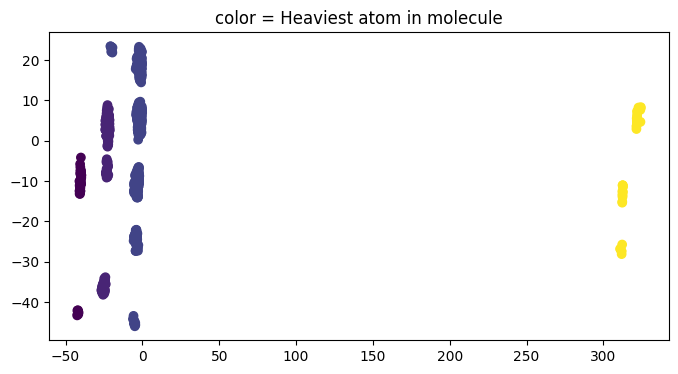

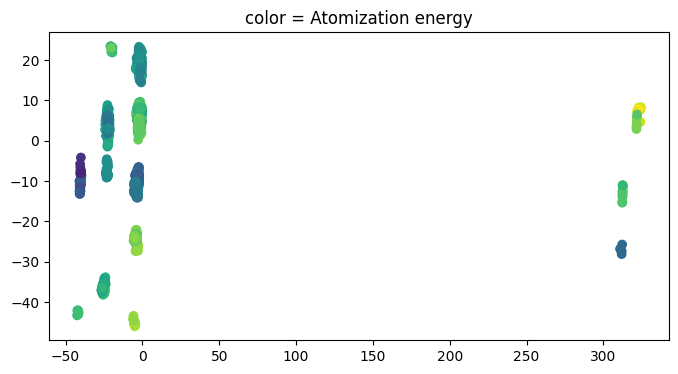

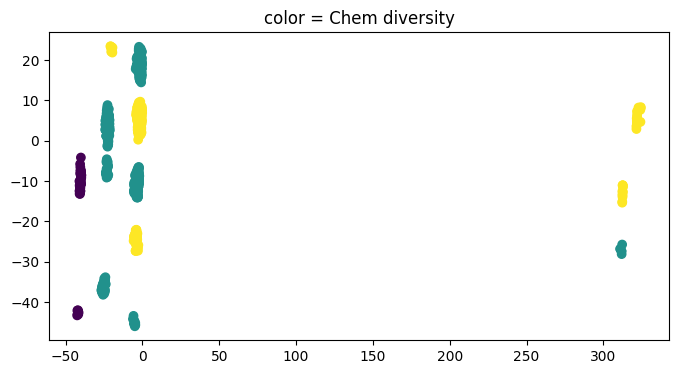

In [11]:
fig_size = (8, 4)

plt.figure(figsize=fig_size)
max_Z = qm7_data['Z'].max(axis=1)
print(max_Z)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=max_Z)
plt.title("color = Heaviest atom in molecule")
plt.show()

# Second plot: Atomization energy
plt.figure(figsize=fig_size)
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=qm7_data["T"])
plt.title("color = Atomization energy")
plt.show()

# Third plot: Chemical diversity
plt.figure(figsize=fig_size)
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=df_u.nunique(axis=1))
plt.title("color = Chem diversity")
plt.show()

As you can see in the plots above, the first principle component seems to mainly encode information about the heaviest atom in the molecule. In order to further validate this information and to show another way of analyzing the principle components the qm7 dataset will be split into two parts according to the PC1 value (> 250 and < 50). Py3Dmol will be used in order to visualize the structures of the molecule. By looking at different structures from the two PC1 ranges one can see that the main difference between them is the presence or absence of sulfur atoms.

In [12]:
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()



# Change the number in the rectangular bracets below to check different structures
# Change idx_smallest_pc1 to idx_largest_pc1 in order to check the other PC1 range
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_smallest_pc1[5], s)
mol

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

#### With data standardization

In [13]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

In [14]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(qm7_cm))
df_scaled

,0,1,2,3,4,5,6,7,8,9,...,215,216,217,218,219,220,221,222,223,224
0,-0.044549,0.722757,-0.483804,-0.465096,-1.047523,-1.275253,-1.402952,-0.467348,-0.102323,-0.025052,...,-1.369330,-2.136465,1.770912,1.724548,-0.346133,-0.170830,1.859144,-0.852049,0.988651,0.0
1,-0.044549,0.725228,-0.476380,0.906262,-1.037807,-1.803589,-1.410930,-0.434049,-0.137355,0.747407,...,-1.334562,-2.136684,1.809340,1.639142,-0.993904,-0.878766,1.846415,1.199059,-1.290658,0.0
2,-0.044549,0.728975,0.744357,-0.458203,-0.183195,-1.803703,-1.411218,0.059881,0.532819,0.029254,...,-1.242912,-2.067548,-0.727372,-0.649023,-0.956618,2.237051,-0.773411,1.185188,-1.295472,0.0
3,-0.044549,0.718454,-0.508503,0.906193,-0.171030,-1.805138,-1.523623,-0.526795,0.517558,0.034193,...,-1.323124,-2.150048,-0.077073,3.578688,-0.494582,2.250263,-0.400732,-0.825875,-1.096336,0.0
4,-0.723964,0.098569,-0.128764,-0.079294,-0.871444,-1.926379,-1.556895,-0.584487,-0.342716,-0.789746,...,-1.223060,-2.135624,-0.818050,-0.728077,2.983373,2.272133,-0.452575,-0.873451,-1.081588,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-0.418149,0.950632,0.624795,-0.689563,-0.426326,-0.183215,-0.412029,-0.852373,-0.831957,0.463348,...,0.419067,0.556566,-0.442788,-0.179744,-1.095523,-0.843277,0.821287,-1.042932,0.856048,0.0
1215,-0.418149,0.785287,0.626409,-0.664681,-0.305158,-0.210053,-0.270636,-0.890492,-0.761952,-0.728877,...,0.369628,0.535037,-0.336154,-0.653435,1.322095,0.983624,1.844822,1.194901,-1.267976,0.0
1216,-0.723964,-0.125038,-0.934655,0.006048,-0.689139,-0.593179,1.620175,-0.630176,-0.899804,-1.011699,...,-0.623292,0.559996,-0.193912,-0.538604,-0.795345,0.766032,-0.541173,-0.910498,0.847176,0.0
1217,-0.723964,-0.086327,-0.047584,-0.942256,-0.678343,0.985074,-0.047409,-1.102956,-1.064490,-0.284456,...,-0.542386,0.559233,0.961996,0.978596,-0.849560,-0.206499,1.688425,-0.832395,-1.078552,0.0


In [15]:
pca = PCA(n_components=2)
pca.fit(df_scaled)

PCA(n_components=2)

In [16]:
X_reduced_scaled = pca.transform(df_scaled)
X_reduced_scaled

array([[-11.536528  ,  -4.49958   ],
       [-10.823381  ,  -4.39698   ],
       [-11.392933  ,  -3.824424  ],
       ...,
       [  0.32703987,  -0.13212703],
       [  0.14471477,  -3.0916805 ],
       [  0.57725376,  -3.3227162 ]], dtype=float32)

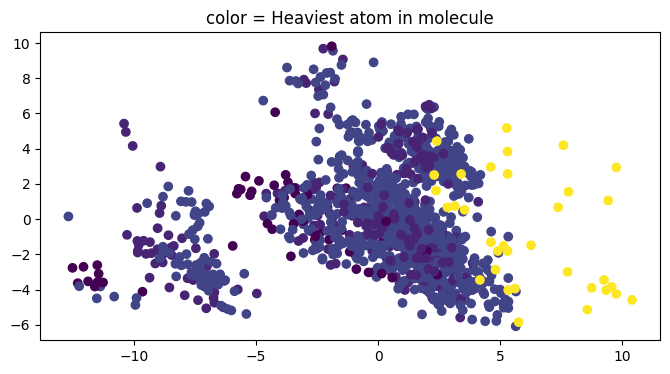

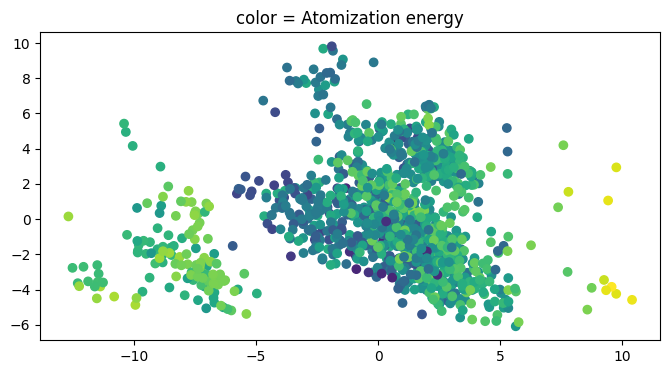

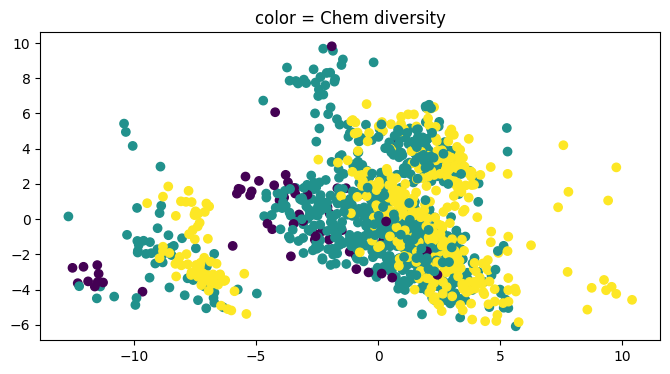

In [17]:

fig_size = (8, 4)

# First plot: Heaviest atom in molecule
plt.figure(figsize=fig_size)
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=max_Z)
plt.title("color = Heaviest atom in molecule")
plt.show()

# Second plot: Atomization energy
plt.figure(figsize=fig_size)
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=qm7_data["T"])
plt.title("color = Atomization energy")
plt.show()

# Third plot: Chemical diversity
plt.figure(figsize=fig_size)
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_reduced_scaled[:, 0], X_reduced_scaled[:, 1], c=df_u.nunique(axis=1))
plt.title("color = Chem diversity")
plt.show()


### Choosing the number of principal components

Choosing the correct number of PC is vital to successfully reducing the dimensionality of your data. If the number of principle components is set to low not all of the variance in the data is accounted for, while too many principle components can be redundant. In order to evaluate how many PCs to choose the explained variance ratio for each principle component can be calculated and visualized. In the following section, PCA is performed for 8 PCs and visualized.

[0.06134311 0.04071222 0.03209444 0.0309252  0.02384733 0.0228348
 0.02062876 0.01950577]


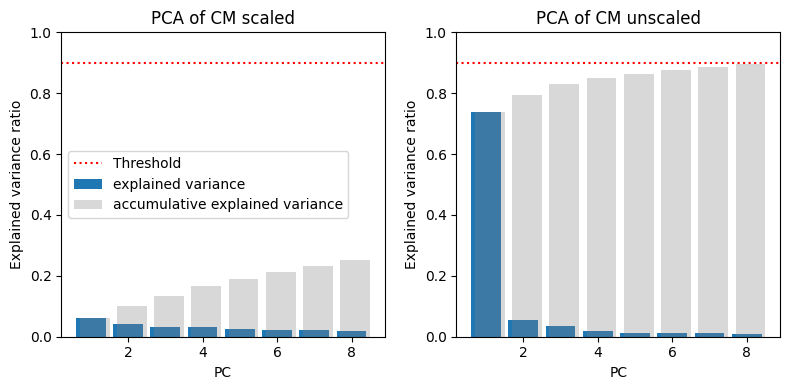

In [18]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.subplot(1, 2, 1)
pca_scaled = PCA(n_components=8)
pca_scaled.fit(df_scaled)
X_new_scaled = pca_scaled.transform(df_scaled)
pcs_scaled = np.arange(len(pca_scaled.explained_variance_ratio_))+1
print (pca_scaled.explained_variance_ratio_)
s = 0
cumsum = [(s:=s+i) for i in pca_scaled.explained_variance_ratio_]
plt.bar(pcs_scaled, pca_scaled.explained_variance_ratio_,label="explained variance")
plt.bar(pcs_scaled+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM scaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
plt.axhline(y = 0.9, color = 'r', linestyle = ':',label="Threshold")
plt.legend(loc="center left")

plt.subplot(1, 2, 2)
pca = PCA(n_components=8)
pca.fit(df_qm7_cm)
X_new = pca.transform(df_qm7_cm)
pcs = np.arange(len(pca.explained_variance_ratio_))+1
s = 0
cumsum = [(s:=s+i) for i in pca.explained_variance_ratio_]
plt.bar(pcs, pca.explained_variance_ratio_,label="explained variance")
plt.bar(pcs+0.1, cumsum, color="gray", alpha = 0.3,label="accumulative explained variance")
plt.title("PCA of CM unscaled")
plt.xlabel("PC")
plt.ylabel("Explained variance ratio")
plt.ylim(0,1)
#plt.legend(loc="center left")
plt.axhline(y = 0.9, color = 'r', linestyle = ':')


plt.tight_layout()


#### Comparison of scaled vs. unscaled Coulomb matrix for PCA
As can be seen above the explained variance for the 8 first principle components is lower for the scaled Coulomb matrix than for the unscaled one. Althogh on the first glance the results from the PCA of the unscaled Coulomb matrix look more promising i.e. more variance explained with fewer principle components. Sadly this is missleading in this example.
    -> Take a closer look at the coulomb matrix and think about why normalization might be needed an why an unormalized Coulomb matrix leads to a seemingly "better PCA".
This example highlights why it is important to inspect the principle component (e.g. with plotting it according to different values, or visualizing a few molecules from one PC range).

### Interpretation of principal components

In [34]:
pca = PCA(n_components=8)
pca.fit(df_scaled)
X_reduced = pca.transform(df_scaled)

In [35]:
df_importance = pd.DataFrame(pca.components_)
df_importance = df_importance.apply(np.abs)
df_importance = df_importance.transpose()
df_importance.columns = ["PC1", "PC2", "PC3", "PC4", "PC5", "PC6", "PC7", "PC8"]
df_importance.head(5)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
0,0.091022,0.010974,0.274977,0.106518,0.000973,0.021807,0.009381,0.092439
1,0.048404,0.003758,0.180352,0.146371,0.042871,0.018109,0.008548,0.037490
2,0.037316,0.022125,0.237683,0.141988,0.018338,0.057511,0.030904,0.019999
3,0.080984,0.013569,0.163315,0.044805,0.018371,0.103961,0.103003,0.075843
4,0.072896,0.003013,0.147152,0.003928,0.011428,0.092416,0.085173,0.078012


In [36]:
df_importance["PC1"].sort_values(ascending=False)

96     0.213252
111    0.198512
97     0.198512
98     0.182100
126    0.182100
         ...   
128    0.000000
64     0.000000
112    0.000000
208    0.000000
224    0.000000
Name: PC1, Length: 225, dtype: float32

By analyzing the importance of the input features for the principle components information about which original feature influences the principle component most can be obtained. This allows for some interpretibility of the principle components.  

### Visualizing the molecular structures

In [37]:
df_pca_cm = pd.DataFrame(X_reduced)
idx_largest_pc1 = df_pca_cm[df_pca_cm[0] > 250].index.tolist()
idx_smallest_pc1 = df_pca_cm[df_pca_cm[0] < 50].index.tolist()

In [38]:
df_pca_cm

,0,1,2,3,4,5,6,7
0,-11.536665,-4.496965,2.328173,-0.664365,1.771394,-4.406290,-4.358758,-1.243400
1,-10.823525,-4.392376,2.657567,1.547248,5.132460,-2.117720,-4.997316,-2.936549
2,-11.393022,-3.826162,3.845270,-0.342998,3.462421,-0.594644,-0.403394,-2.437553
3,-9.955043,-4.870899,5.039521,-1.718563,3.440332,-0.375002,0.740401,-3.492577
4,-12.318563,-3.635606,1.210481,1.138284,3.816565,-1.504573,-1.773209,-3.191529
...,...,...,...,...,...,...,...,...
1214,-0.449286,-0.224586,0.251970,-1.060191,-2.508068,1.044479,2.725190,1.690445
1215,0.931537,-0.884314,-0.967150,-0.022012,4.286368,-1.077158,1.491506,1.916308
1216,0.327045,-0.132839,-1.972596,-2.037261,-3.093386,0.516758,0.111189,-1.645137
1217,0.144697,-3.090410,-2.449382,0.855698,4.001059,-1.597578,1.600699,-0.043296


In [39]:
idx_largest_pc1

[]

In [40]:
s = {'stick': {'radius': .15}, 'sphere': {'scale': 0.20}}
mol = view_molecule(qm7_data, idx_largest_pc1[5], s)
mol

IndexError: list index out of range

In [41]:
mol = view_molecule(qm7_data, idx_smallest_pc1[22], s)
mol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

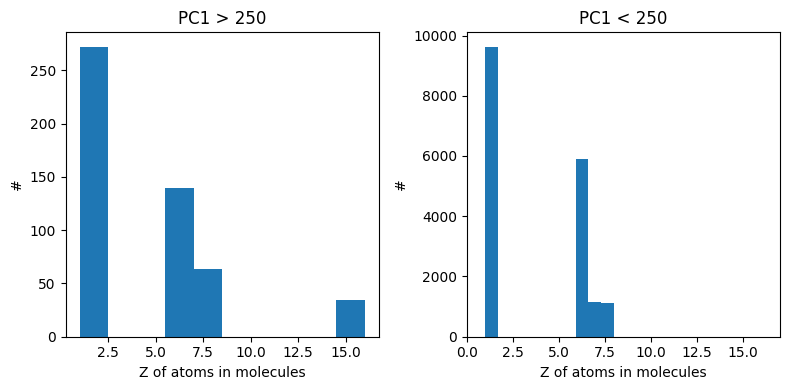

In [42]:
fig_size = (8, 4)
df_X_new = pd.DataFrame(X_new)
plt.figure(figsize=fig_size)

# First subplot: PC1 > 250
plt.subplot(1, 2, 1)
df_X_new_filtered = df_X_new.loc[df_X_new[0] > 250]
test = pd.DataFrame(qm7_data['Z'][list(df_X_new_filtered.index.values)])
plt.hist(test.stack())
plt.xlabel("Z of atoms in molecules")
plt.ylabel("#")
plt.title("PC1 > 250")

# Second subplot: PC1 < 250
plt.subplot(1, 2, 2)
df_X_new_filtered = df_X_new.loc[df_X_new[0] < 250]
test = pd.DataFrame(qm7_data['Z'][list(df_X_new_filtered.index.values)])
plt.hist(test.stack())
plt.xlabel("Z of atoms in molecules")  # Added xlabel for consistency
plt.ylabel("#")
plt.title("PC1 < 250")
plt.xlim(0, 17)

# Display the plots
plt.tight_layout()  # Adjusts subplot params to give specified padding
plt.show()


To evaluate the seperation of molecules by the first principle component for the unscaled dataset the number of atoms for molecules showing a PC 1 of over or under 250 is plotted above. Molecules with a PC1 over 250 are made of Sulfur atoms (Z=16), whilst molecules with a PC1 under 250 are not.

## t-SNE

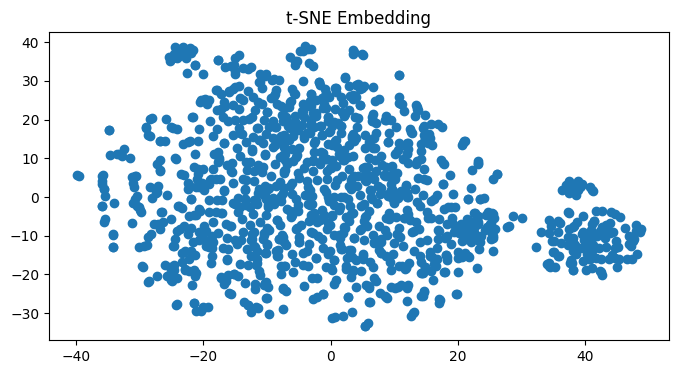

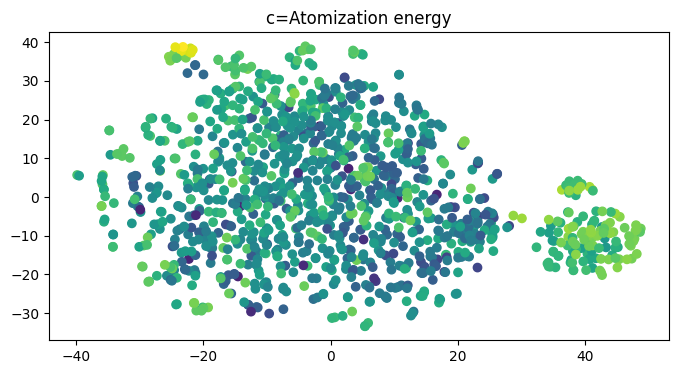

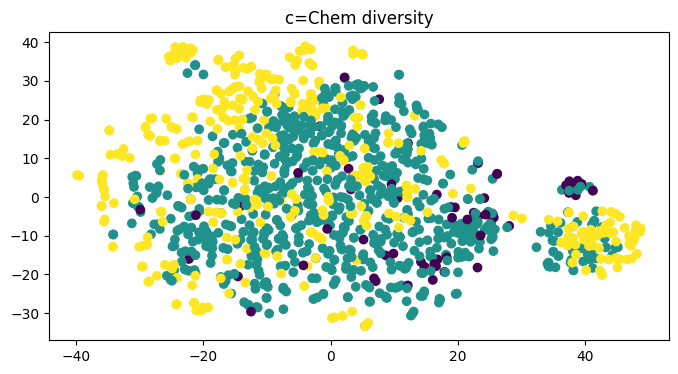

In [156]:
from sklearn.manifold import TSNE
fig_size = (8, 4)
X_embedded = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=50).fit_transform(df_scaled)

# First plot: t-SNE embedding without coloring
plt.figure(figsize=fig_size)
plt.scatter(X_embedded.T[0], X_embedded.T[1])
plt.title("t-SNE Embedding")
plt.show()

# Second plot: t-SNE embedding colored by atomization energy
plt.figure(figsize=fig_size)
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=qm7_data["T"])
plt.title("c=Atomization energy")
plt.show()

# Third plot: t-SNE embedding colored by chemical diversity
plt.figure(figsize=fig_size)
df_u = pd.DataFrame(qm7_data["Z"])
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=df_u.nunique(axis=1))
plt.title("c=Chem diversity")
plt.show()
